#Inicio

In [1]:
!pip install sentence_transformers umap umap-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.7 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=cf49d2480d965d07de98aacdb7be66d3f27d2f20d496af165948f77177c73932
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [2]:
import os
import json
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorboard.plugins.projector import visualize_embeddings, ProjectorConfig
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


#Clusterização

In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import json
import numpy as np
import os

# Initialize the sentence transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Load the list of file names
with open('/content/selected_files.txt', 'r') as f:
    file_names = [line.strip() for line in f.readlines()]

# Folder containing the original JSON files
folder_path = '/content/drive/MyDrive/SOFIA/descricao/Resultados_descrição'

# Initialize a list to store embeddings and their associated file names
embeddings = []
file_paths = []

# Encode each description
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    try:
        with open(file_path, 'r', encoding='utf-8') as json_file:
            data = json.load(json_file)
            description = data['choices'][0]['message']['content']  # Adjust this if the description field has a different key
            if description:
                embedding = model.encode(description)
                embeddings.append(embedding)
                file_paths.append(file_path)
    except FileNotFoundError:
        print(f"File {file_name} not found.")
    except json.JSONDecodeError:
        print(f"Could not decode JSON from file {file_name}.")

# Convert list of embeddings to numpy array
embeddings = np.array(embeddings)

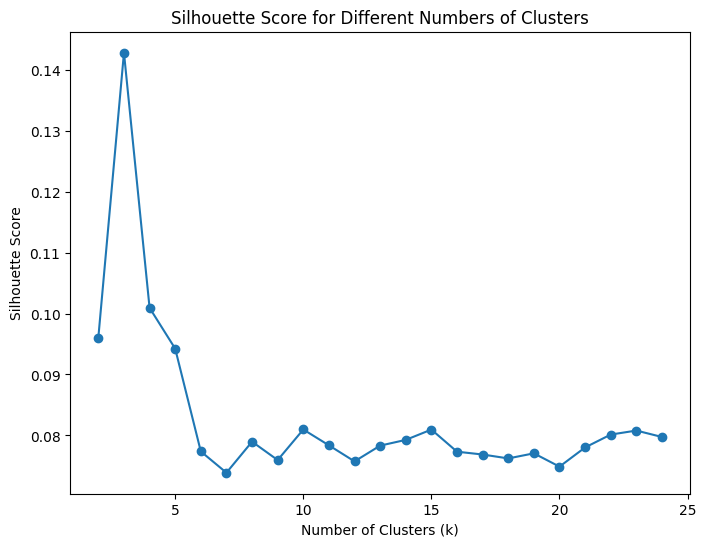

Optimal number of clusters based on silhouette score: 3


In [19]:
# Range of cluster numbers to evaluate
cluster_range = range(2, 25)
silhouette_scores = []

# Calculate silhouette scores for each number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Find the optimal number of clusters (k) with the highest silhouette score
optimal_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")


<ipython-input-7-5e3ccc143b3c>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)


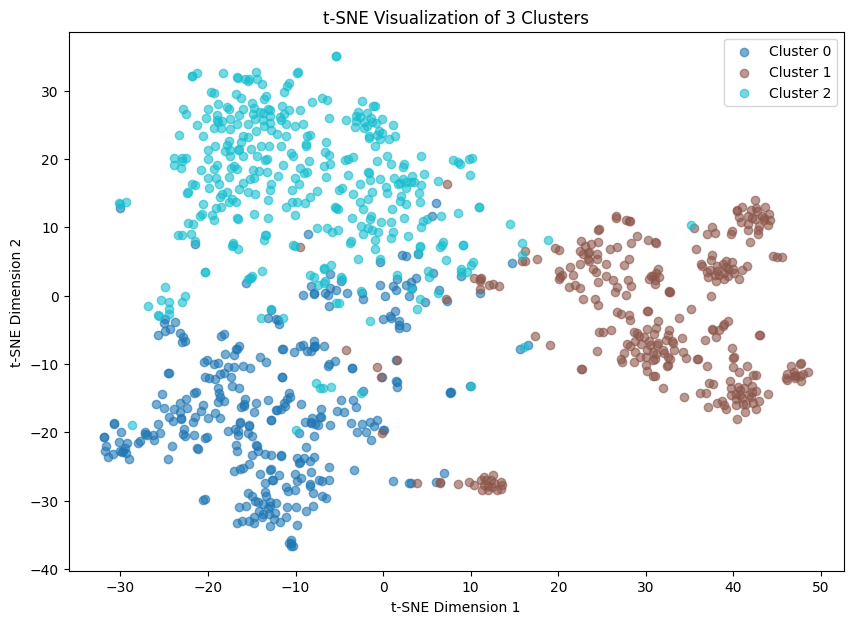

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Set the number of clusters to 3
num_clusters = 3

# Perform KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Prepare color map for the 3 clusters
colors = plt.cm.get_cmap("tab10", num_clusters)

# Plot each cluster with a different color
plt.figure(figsize=(10, 7))
for cluster_id in range(num_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_points = embeddings_2d[cluster_indices]

    # Scatter plot for each cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f"Cluster {cluster_id}",
                color=colors(cluster_id),
                alpha=0.6)

# Final plot adjustments
plt.title("t-SNE Visualization of 3 Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="best")
plt.show()

In [10]:
# Create 3 text files, one for each cluster, and write the file names of each cluster
for cluster_id in range(num_clusters):
    # Get indices of files in the current cluster
    cluster_indices = np.where(labels == cluster_id)[0]

    # Get the file names for this cluster
    cluster_file_names = [file_paths[i] for i in cluster_indices]

    # Write the file names to a text file for this cluster
    file_name = f"cluster_{cluster_id}_files.txt"
    with open(file_name, "w") as f:
        for file_path in cluster_file_names:
            f.write(file_path + "\n")
    print(f"Cluster {cluster_id} has {len(cluster_file_names)} elements")
    print(f"File names for Cluster {cluster_id} saved to {file_name}")


Cluster 0 has 328 elements
File names for Cluster 0 saved to cluster_0_files.txt
Cluster 1 has 301 elements
File names for Cluster 1 saved to cluster_1_files.txt
Cluster 2 has 371 elements
File names for Cluster 2 saved to cluster_2_files.txt


In [13]:
from sklearn.cluster import KMeans
import numpy as np

# Set the number of clusters
num_clusters = 3
representative_per_cluster = 34
closest_count = 17
farthest_count = 17

# Perform KMeans clustering with a fixed random state for consistency
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)
centroids = kmeans.cluster_centers_

# Dictionary to store selected files for each cluster
selected_files_by_cluster = {}

# Loop over each cluster to select representative files
for cluster_id in range(num_clusters):
    # Get indices of files in the current cluster
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_embeddings = embeddings[cluster_indices]
    centroid = centroids[cluster_id]

    # Compute distances to centroid for each point in the cluster
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

    # Sort indices by distance to centroid
    sorted_indices = cluster_indices[np.argsort(distances)]

    # Select the 17 closest and 17 farthest files
    closest_indices = sorted_indices[:closest_count]
    farthest_indices = sorted_indices[-farthest_count:]

    # Combine the closest and farthest indices
    selected_indices = np.concatenate((closest_indices, farthest_indices))

    # Store the selected file paths for this cluster
    selected_files_by_cluster[cluster_id] = [file_paths[i] for i in selected_indices]

    # Save the selected file names to a text file for this cluster
    file_name = f"cluster_{cluster_id}_selected_files.txt"
    with open(file_name, "w") as f:
        for file_path in selected_files_by_cluster[cluster_id]:
            f.write(file_path + "\n")

    print(f"Selected representative files for Cluster {cluster_id} saved to {file_name}")

# Combine all selected files into one list if needed
all_selected_files = [file for files in selected_files_by_cluster.values() for file in files]


Selected representative files for Cluster 0 saved to cluster_0_selected_files.txt
Selected representative files for Cluster 1 saved to cluster_1_selected_files.txt
Selected representative files for Cluster 2 saved to cluster_2_selected_files.txt


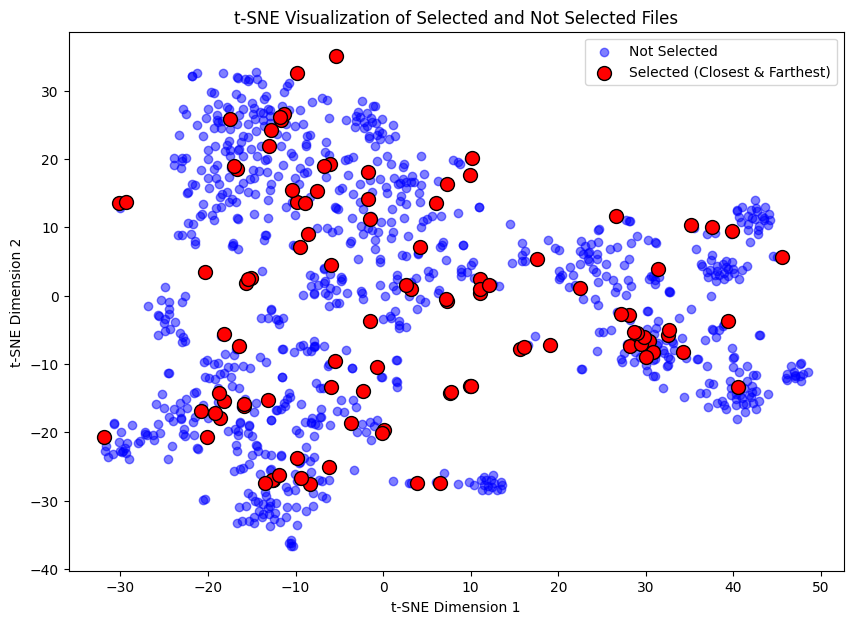

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Set the number of clusters and selections
num_clusters = 3
closest_count = 17
farthest_count = 17

# Perform KMeans clustering with a fixed random state for consistency
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)
centroids = kmeans.cluster_centers_

# Collect selected indices
selected_indices = []

# Loop over each cluster to select the closest and farthest files
for cluster_id in range(num_clusters):
    # Get indices of files in the current cluster
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_embeddings = embeddings[cluster_indices]
    centroid = centroids[cluster_id]

    # Compute distances to centroid for each point in the cluster
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

    # Sort indices by distance to centroid
    sorted_indices = cluster_indices[np.argsort(distances)]

    # Select the 17 closest and 17 farthest files
    closest_indices = sorted_indices[:closest_count]
    farthest_indices = sorted_indices[-farthest_count:]

    # Combine and add to the selected indices list
    selected_indices.extend(closest_indices)
    selected_indices.extend(farthest_indices)

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Create boolean mask arrays for selected and not selected files
selected_mask = np.zeros(len(embeddings), dtype=bool)
selected_mask[selected_indices] = True
not_selected_mask = ~selected_mask

# Plot selected and not selected points
plt.figure(figsize=(10, 7))

# Plot not selected files
plt.scatter(embeddings_2d[not_selected_mask, 0], embeddings_2d[not_selected_mask, 1],
            color='blue', alpha=0.5, label="Not Selected")

# Plot selected files
plt.scatter(embeddings_2d[selected_mask, 0], embeddings_2d[selected_mask, 1],
            color='red', edgecolor='black', s=100, label="Selected (Closest & Farthest)")

# Add plot details
plt.title("t-SNE Visualization of Selected and Not Selected Files")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="best")
plt.show()


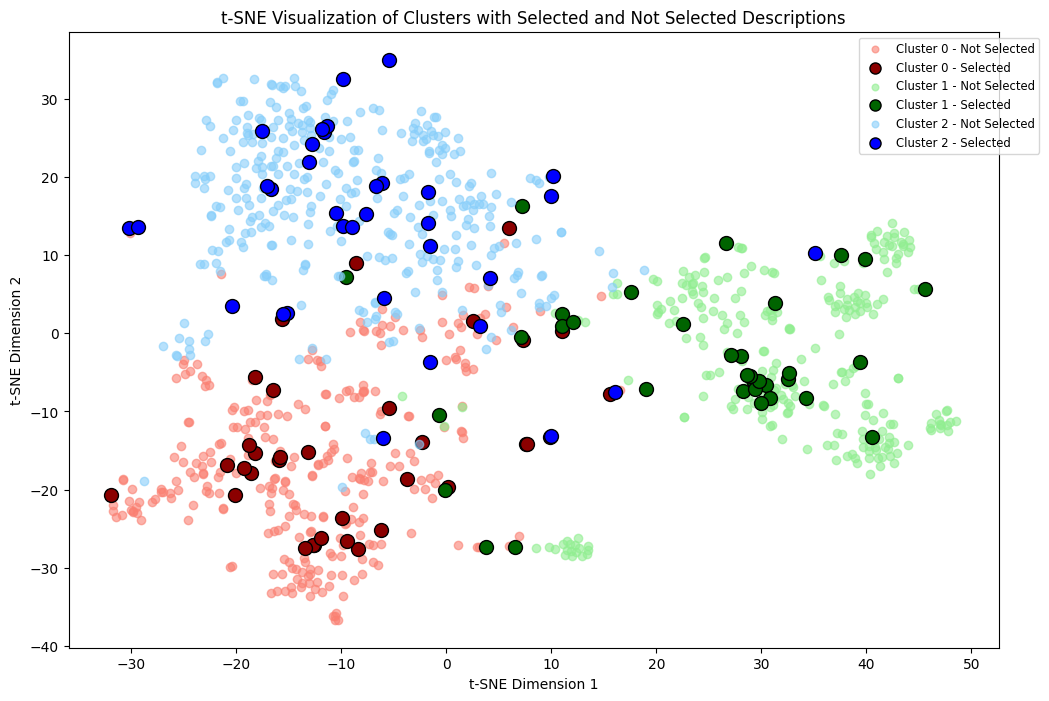

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Set the number of clusters and selections
num_clusters = 3
closest_count = 17
farthest_count = 17

# Perform KMeans clustering with a fixed random state for consistency
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)
centroids = kmeans.cluster_centers_

# Collect selected indices
selected_indices = []

# Loop over each cluster to select the closest and farthest files
for cluster_id in range(num_clusters):
    # Get indices of files in the current cluster
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_embeddings = embeddings[cluster_indices]
    centroid = centroids[cluster_id]

    # Compute distances to centroid for each point in the cluster
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

    # Sort indices by distance to centroid
    sorted_indices = cluster_indices[np.argsort(distances)]

    # Select the 17 closest and 17 farthest files
    closest_indices = sorted_indices[:closest_count]
    farthest_indices = sorted_indices[-farthest_count:]

    # Combine and add to the selected indices list
    selected_indices.extend(closest_indices)
    selected_indices.extend(farthest_indices)

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Define custom colors for each cluster
cluster_colors = {
    0: {"not_selected": "salmon", "selected": "darkred"},
    1: {"not_selected": "lightgreen", "selected": "darkgreen"},
    2: {"not_selected": "lightskyblue", "selected": "blue"}
}

# Plot each cluster with selected and not selected points
plt.figure(figsize=(12, 8))

for cluster_id in range(num_clusters):
    # Mask for the current cluster
    cluster_mask = (labels == cluster_id)

    # Separate selected and not selected points within this cluster
    selected_cluster_mask = cluster_mask & np.isin(np.arange(len(embeddings)), selected_indices)
    not_selected_cluster_mask = cluster_mask & ~np.isin(np.arange(len(embeddings)), selected_indices)

    # Plot not selected points for this cluster
    plt.scatter(embeddings_2d[not_selected_cluster_mask, 0],
                embeddings_2d[not_selected_cluster_mask, 1],
                color=cluster_colors[cluster_id]["not_selected"], alpha=0.6,
                label=f"Cluster {cluster_id} - Not Selected")

    # Plot selected points for this cluster with black edge
    plt.scatter(embeddings_2d[selected_cluster_mask, 0],
                embeddings_2d[selected_cluster_mask, 1],
                color=cluster_colors[cluster_id]["selected"], edgecolor='black', s=100,
                label=f"Cluster {cluster_id} - Selected")

# Add plot details
plt.title("t-SNE Visualization of Clusters with Selected and Not Selected Descriptions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="best", markerscale=0.8, bbox_to_anchor=(1.05, 1), fontsize="small")
plt.show()
